# S06 - Modèles de partitionnement de données <a class="tocSkip">
Dans cet exercice, nous allons explorer un jeu de données adapté sur les expéditions et les prix de produits de santé. Plus précisément, le jeu de données identifie les expéditions d'antirétroviraux (ARV) et de laboratoires VIH vers les pays soutenus. En outre, le jeu de données fournit les prix des produits et les dépenses associées de la chaîne logistique nécessaires pour acheminer les produits vers ces pays. Les données originales sont fournies par l'Agence américaine pour le développement international et peuvent être consultées sur [cette page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Chargement des données

Comme dans le chapitre, nous allons importer les données.

In [2]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(url)  # importation des données

# Élimination des charactères spéciaux et remplacement des espaces
df_SC.columns = df_SC.columns.str.replace(' ', '_', regex=False)
df_SC.columns = df_SC.columns.str.replace('(', '', regex=False)
df_SC.columns = df_SC.columns.str.replace(')', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('#', '', regex=False)
df_SC.columns = df_SC.columns.str.replace('/', '', regex=False)

# Transformation des types de données
df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')

# conserver seulement les données après 2010
mask = df_SC['delivered_to_client_date'] >= '2010-01-01'
df_SC = df_SC[mask]

# conserver seulement les colonnes intéressantes
selected_columns = ['country', 'line_item_value', 'weight_kilograms', 'freight_cost_usd']
df_SC = df_SC[selected_columns]

# conserver seulement les lignes sans valeurs manquantes
df_SC = df_SC.dropna()
df_SC.head()

C:\Users\11143054\AppData\Local\Temp\ipykernel_23468\468696258.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')


,country,line_item_value,weight_kilograms,freight_cost_usd
18,Vietnam,3465.00,34.0,807.47
1425,Mozambique,5721.60,205.0,1380.45
1426,Nigeria,58.75,1.0,19480.97
1609,Tanzania,136573.92,640.0,2751.00
2068,Ethiopia,74066.00,2031.0,6774.59


Puisque l'analyse de clustering sera effectuée au niveau du pays, nous utilisons la méthode `groupby` pour préparer les données. La méthode `DataFrame.groupby(...).agg(...)` nous permet d'agréger chaque colonne différemment en fonction de ce qui est spécifié dans le dictionnaire. Pour plus d'information, vous pouvez consulter les liens suivants: [lien1](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.core.groupby.DataFrameGroupBy.agg.html) et [lien2](https://pbpython.com/groupby-agg.html).

De plus, puisque les algorithmes de clustering sont typiquement fortement influencés par l'échelle (c.-à-d., qu'ils ne sont pas invariants à l'échelle), une pratique courante est de mettre à l'échelle les données avant de les utiliser. Nous optons pour la standardisation `z-score`. Nous conservons également la liste des noms de colonnes contenant les valeurs initiales et les valeurs standardisées afin de faciliter la tâche lors d'une référence.

In [3]:
df_SC_selected = df_SC.groupby(['country']).agg({'line_item_value': 'sum',
                                                 'weight_kilograms': 'mean',
                                                 'freight_cost_usd': 'mean'})

for col in df_SC_selected.columns:
    df_SC_selected['z_'+col] = (df_SC_selected[col] - df_SC_selected[col].mean()) / df_SC_selected[col].std()

normal_columns = list(df_SC_selected.columns[:3])
z_columns = list(df_SC_selected.columns[3:])

df_SC_selected.head()

,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd
country,,,,,,
Afghanistan,1736.00,44.500000,540.525000,-0.561087,-0.957089,-1.250062
Angola,181600.00,362.200000,6166.414000,-0.557071,-0.808194,-0.499511
Benin,545480.52,2323.600000,11638.258000,-0.548946,0.111043,0.230490
Botswana,1303710.71,525.766667,3451.025333,-0.532016,-0.731536,-0.861771
Burundi,2277173.52,512.750000,5572.184286,-0.510279,-0.737637,-0.578787


# Modèle 1: k-means

Nous appliquons d'abord l'algorithme de clustering k-means en utilisant la librairie *scikit-learn*. La classe `sklearn.cluster.KMeans(...)` retourne un objet qui donne plusieurs résultats (lien fourni ci-dessous). La sortie principale est `.labels_` (notez que c'est un nom d'attribut) qui retourne la liste contenant l'étiquette de groupe de toutes les données. Afin d'apprendre les étiquettes à partir des données, nous devons préalablement appeler `.fit(X)` pour passer les variables d'entrée `X` (nos variables normalisées par le z-score) à la méthode.

[Lien vers la description](https://scikit-learn.org/stable/modules/clustering.html#k-means) et [lien vers la classe KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

In [4]:
# sélectionnons les données que nous voulons utiliser
X = df_SC_selected[z_columns]

# initialisons une objet k-means avec 3 groupes et entraînons le sur les données
# étant donné qu'il y a une part d'aléatoire dans l'algorithme, nous fixons aussi
# `random_state=0` pour s'assurer de toujours avoir le même résultat
kmeans_object = KMeans(n_clusters=3, random_state=0)
kmeans_object.fit(X)

# nous obtenons maintenant la liste des étiquettes de groupes et l'ajoutons au DataFrame
# il se peut que les numéros de groupe change au fil du temps, mais les groupes demeureront les même
df_SC_selected['K3_cluster'] = kmeans_object.labels_
df_SC_selected.head()

,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster
country,,,,,,,
Afghanistan,1736.00,44.500000,540.525000,-0.561087,-0.957089,-1.250062,0
Angola,181600.00,362.200000,6166.414000,-0.557071,-0.808194,-0.499511,0
Benin,545480.52,2323.600000,11638.258000,-0.548946,0.111043,0.230490,0
Botswana,1303710.71,525.766667,3451.025333,-0.532016,-0.731536,-0.861771,0
Burundi,2277173.52,512.750000,5572.184286,-0.510279,-0.737637,-0.578787,0


c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


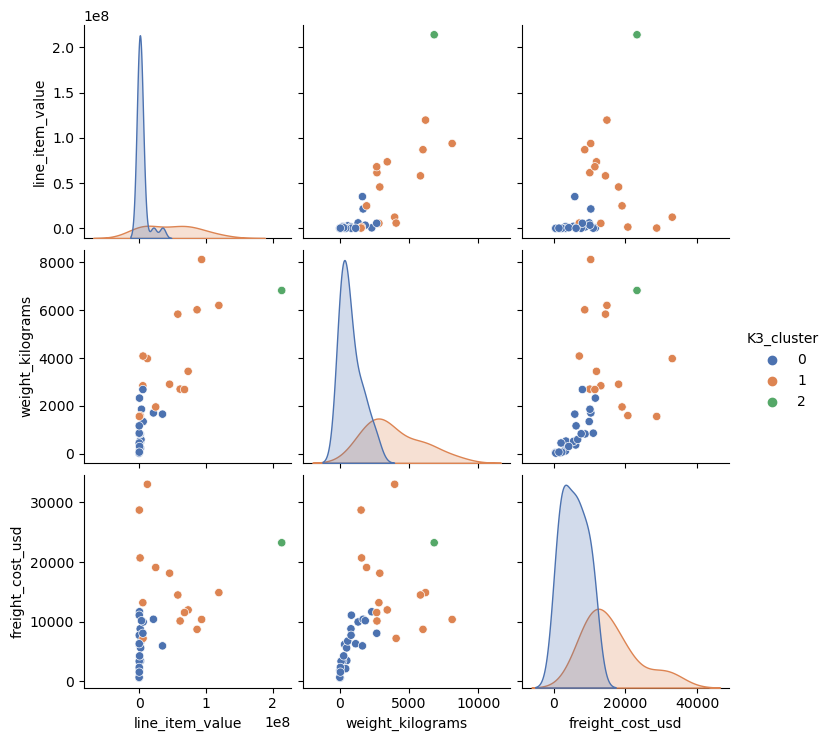

In [5]:
sns.pairplot(data=df_SC_selected[normal_columns+["K3_cluster"]], hue='K3_cluster', palette='deep')

Afin de choisir le nombre optimal de groupes (dans le cas où il n'est pas prédéfini), nous pouvons comparer les résultats de différents nombres de groupes basés sur:

* l'**inertie** ou la somme des carrés (SSE) au sein des groupes : Celle-ci mesure la compacité de chaque groupe. Il s'agit de la fonction objective que l'algorithme standard k-means optimise (voir [lien](https://scikit-learn.org/stable/modules/clustering.html)). Elle peut être obtenue par l'attribut `.inertia_` de l'objet k-means. 
* la valeur **silhouette** : Celle-ci représente la façon dont les clusters sont séparés les uns des autres (voir [lien](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)). Cela peut être fait avec la fonction `sklearn.metrics.silhouette_score(X, cluster_labels)`.

En pratique, un nombre plus petit de groupes est généralement préféré. Nous choisissons donc le nombre de groupes où des améliorations significatives sont observées dans les deux mesures parmi des choix raisonnables de $k$.

c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\11143054\AppData\Local\miniconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

<Axes: >

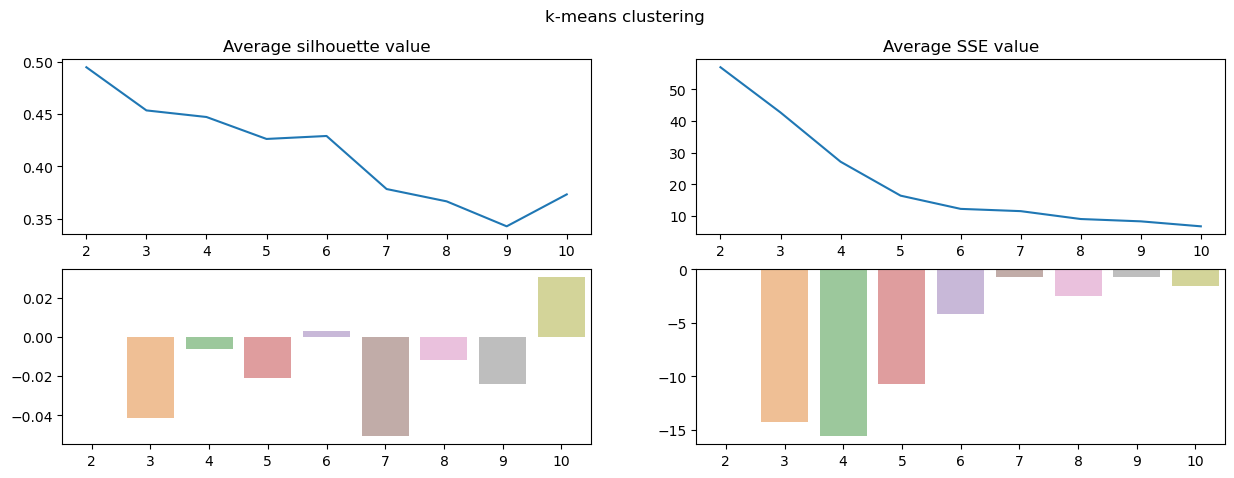

In [6]:
# nombre de groupes à explorer
kmeans_range = list(range(2,11))

# listes vides pour enregistrer les résultats
inertia_list = []
silhouette_list = []

for k in kmeans_range:
    # entraîner l'algorithme
    kmeans_object = KMeans(n_clusters=k, random_state=0).fit(X)

    # enregistrer l'inertie
    inertia_list.append(kmeans_object.inertia_)

    # calculer la valeur de la silhouette et l'enregistrer
    silhouette_val = silhouette_score(X, kmeans_object.labels_)
    silhouette_list.append(silhouette_val)

# calculer la différence marginale de l'inertie pour chaque valeur de k
diff_inertia = [inertia_list[i] - inertia_list[max(0,i-1)] for i in range(len(kmeans_range))]
# calculer la différence marginale de la silhouette pour chaque valeur de k
diff_silhouette = [silhouette_list[i] - silhouette_list[max(0,i-1)] for i in range(len(kmeans_range))]

# tracer les résultats avec une grille de 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('k-means clustering')

sns.lineplot(ax=axes[0,0], x=kmeans_range, y=silhouette_list).set_title('Average silhouette value')
sns.lineplot(ax=axes[0,1], x=kmeans_range, y=inertia_list).set_title('Average SSE value')
sns.barplot(ax=axes[1,0], x=kmeans_range, y=diff_silhouette, alpha=0.5)
sns.barplot(ax=axes[1,1], x=kmeans_range, y=diff_inertia, alpha=0.5)

On aurait tendance à choisir 2 groupes avec la silhouette et 5 groupes avec l'inertie.

# Modèle 2: clustering agglomérant

Dans certains cas, nous devons créer une hiérarchie de groupes plutôt qu'un seul niveau de groupes pour permettre différents niveaux d'agrégation et de désagrégation (par exemple, hiérarchie produit/client). L'une des méthodes couramment utilisées est le clustering agglomérant, qui peut être utilisé pour assurer la cohérence hiérarchique des groupes. Vous trouverez plus de détails sur [lien vers la description](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) et [lien vers la fonction](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

Ici, nous allons démontrer le concept en montrant les résultats basés sur le nombre de groupes $k=2, 3, 4$. La version par défaut de cette méthode optimise la somme des carrés à l'intérieur des clusters, ce qui est le même objectif que dans le k-means standard (mais d'autres objectifs sont disponibles, comme décrit dans le lien).

In [7]:
# 2 groupes
hcluster2 = AgglomerativeClustering(n_clusters=2).fit(X)
df_SC_selected['A2_cluster'] = hcluster2.labels_
# afficher le nombre de pays sous chaque groupe
print(df_SC_selected['A2_cluster'].value_counts())

# 3 groupes
hcluster3 = AgglomerativeClustering(n_clusters=3).fit(X)
df_SC_selected['A3_cluster'] = hcluster3.labels_
print(df_SC_selected['A3_cluster'].value_counts())

# 4 groupes
hcluster4 = AgglomerativeClustering(n_clusters=4).fit(X)
df_SC_selected['A4_cluster'] = hcluster4.labels_
print(df_SC_selected['A4_cluster'].value_counts())

df_SC_selected.tail(10)

A2_cluster
0    33
1     5
Name: count, dtype: int64
A3_cluster
2    17
0    16
1     5
Name: count, dtype: int64
A4_cluster
2    17
1    11
3     5
0     5
Name: count, dtype: int64


,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster,A2_cluster,A3_cluster,A4_cluster
country,,,,,,,,,,
South Africa,8.685259e+07,6020.439716,8683.827624,1.378208,1.843617,-0.163662,1,1,1,0
South Sudan,6.998661e+05,300.915254,4234.216271,-0.545499,-0.836916,-0.757286,0,0,2,2
Sudan,2.293064e+05,63.714286,1507.975476,-0.556006,-0.948083,-1.120994,0,0,2,2
Swaziland,5.618971e+06,2683.739130,8030.255652,-0.435660,0.279827,-0.250855,0,0,0,1
Tanzania,7.349008e+07,3444.231788,11947.480662,1.079836,0.636242,0.271743,1,0,0,1
Togo,1.532580e+05,1162.500000,6272.360000,-0.557704,-0.433123,-0.485376,0,0,2,2
Uganda,6.803387e+07,2682.802273,11508.059523,0.958004,0.279388,0.213120,1,0,0,1
Vietnam,3.503135e+07,1652.715190,5915.752468,0.221090,-0.203377,-0.532951,0,0,2,2
Zambia,1.195445e+08,6204.486755,14856.484636,2.108185,1.929873,0.659834,1,1,1,0


Nous affichons maintenant les groupes.

Text(0.5, 1.0, 'A4_cluster')

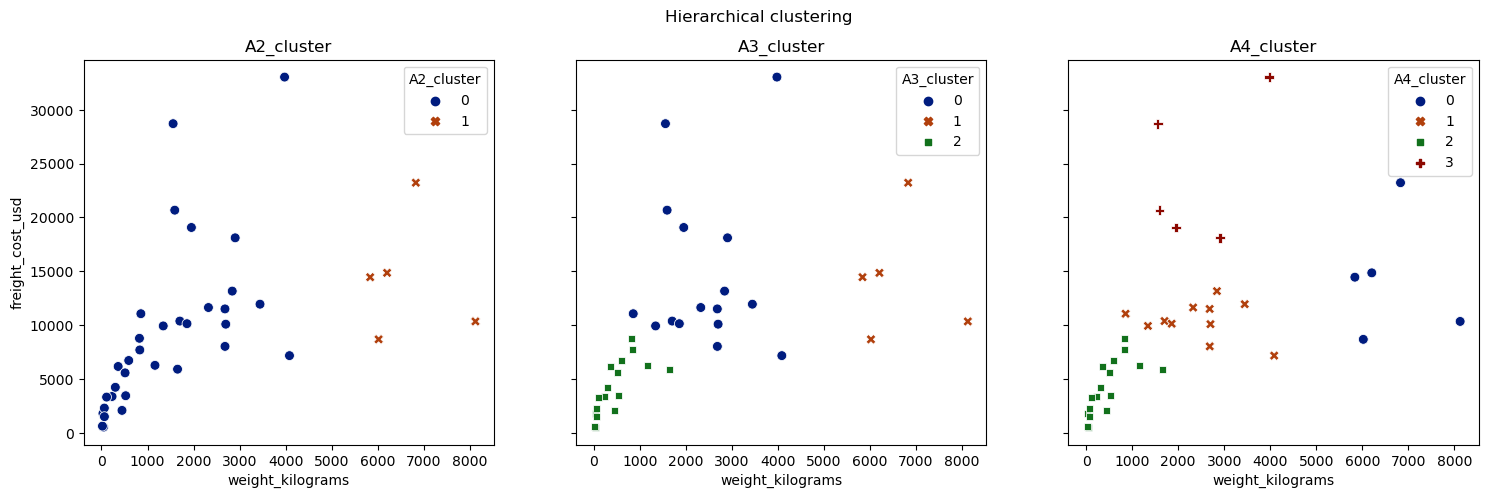

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5),sharey=True)
fig.suptitle('Hierarchical clustering')

# 2 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[0], x=normal_columns[1], y=normal_columns[2],
                hue='A2_cluster', style='A2_cluster', palette='dark', s=50)
axes[0].set_title('A2_cluster')

# 3 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[1], x=normal_columns[1], y=normal_columns[2],
                hue='A3_cluster', style='A3_cluster', palette='dark', s=50)
axes[1].set_title('A3_cluster')

# 4 groupes
sns.scatterplot(data = df_SC_selected, ax=axes[2], x=normal_columns[1], y=normal_columns[2],
                hue='A4_cluster', style='A4_cluster', palette='dark', s=50)
axes[2].set_title('A4_cluster')

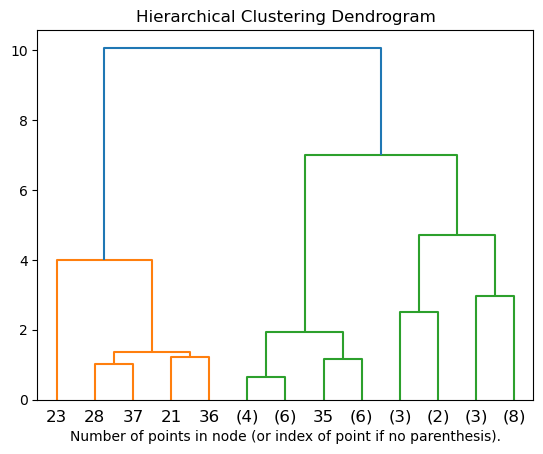

In [10]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
